# Advanced Lane Finding
Anand Dinakar

The goal of this project is to develop a software pipeline to identify the lane boundaries in a video from a front-facing camera on a car.

This is accomplished with the following steps:
1. Camera Calibration: Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Distortion correction on raw images.
3. Use color transforms, gradients to create a thresholded binary image.
4. Apply a perspective transform to create a binary "birds-eye view" image.
5. Detect lane pixels and fit polynomials to find the lane boundaries.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image, augmenting the video with lane marking.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

# Function to draw image with caption
def plotImg(img, caption):
    plt.figure()
    plt.axis('off')
    ht = img.shape[0]+25
    if len(img.shape) == 2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img)    
    plt.text(0,ht,caption)

# Load and return image in RGB space
def loadImage(fname):
    return mpimg.imread(fname)

## Camera Calibration
OpenCV functions are used to calculate the camera matrix using the 19 JPEG images provided in the `camera_cal` folder. For each image, I collect get the chessboard corner points using the `findChessboardCorners` function. 

These points are then passed to the `calibrateCamera` function that returns a `camera matrix` and an array of `distortion coefficients`.

Thee are then used to `undistort` images from the camera. See the effect of `undistortion` in the image below.

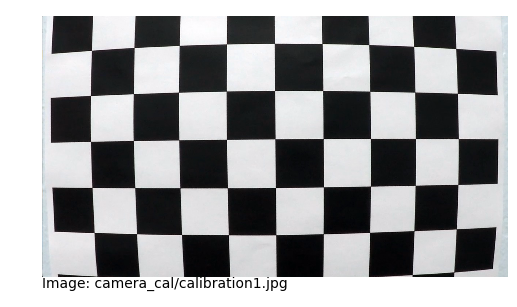

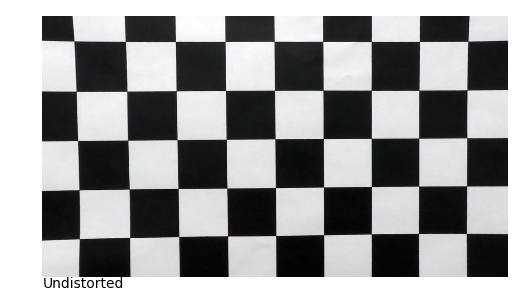

In [2]:
# Calibrate camera for distortion correction
def calibrateCamera(data, calibrationFilesWildcard):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(calibrationFilesWildcard)

    # Step through the list and search for chessboard corners
    for fname in images:
        img = loadImage(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
    data['CameraMatrix'] = mtx
    data['DistortionCoeff'] = dist

# Run calibration
data={}
calibrateCamera(data, 'camera_cal/calibration*.jpg')

# Undistort
fname='camera_cal/calibration1.jpg'
img = cv2.imread(fname)
undist = cv2.undistort(img, data['CameraMatrix'], data['DistortionCoeff'], None, data['CameraMatrix'])

plotImg(img, "Image: {0}".format(fname))
plotImg(undist, "Undistorted")


## Distortion Correction

The `camera matrix` and `distortion coefficients array` are used to `undistort` a sample image. See the effect of `undistort` operaion in the images below.

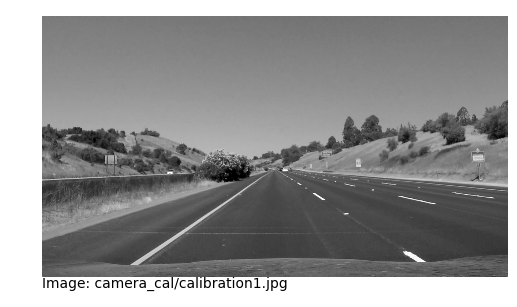

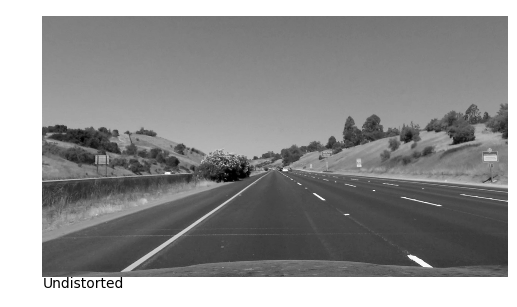

In [3]:
testImage = 'test_images/straight_lines1.jpg'
img = loadImage(testImage)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
undist = cv2.undistort(gray, data['CameraMatrix'], data['DistortionCoeff'], None, data['CameraMatrix'])

plotImg(gray, "Image: {0}".format(fname))
plotImg(undist, "Undistorted")

## Color and Gradient Tresholds

The `extractLaneEdges` function in this section isolates pixels that make up lane lines.

First I convert the color image to HLS and HSV formats to extract the `lightness` channel from HLS image and the `saturation` channel from the HSV.
Then I take the derivatives on the L Channel along x and y axes.

These derivative values are used to compute gradient magnitude and direction.

Pixels are then filtered to retain only areas where:
 1. direction values are within (0.6, 1.4)
 2. and magnitude values are within (30, 100) 
 3. and the derivative along x-axis lies within (20, 100).

Similarly, the S channel are filtered to retain only areas where the raw values lie between (170, 255).
Filtered output from these two are merged into a single binary frame.
The L-channel and S-channel each extract parts of the lane and together provide a complete image of the lanes.

The above tresholds were determined over several trials using the test images provided. 


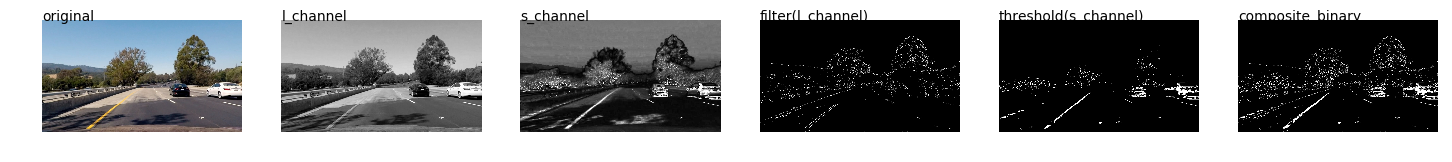

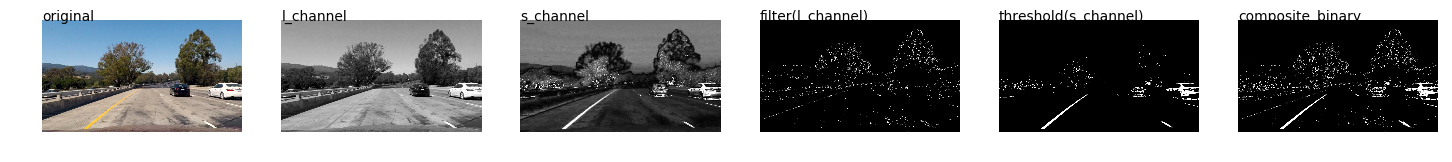

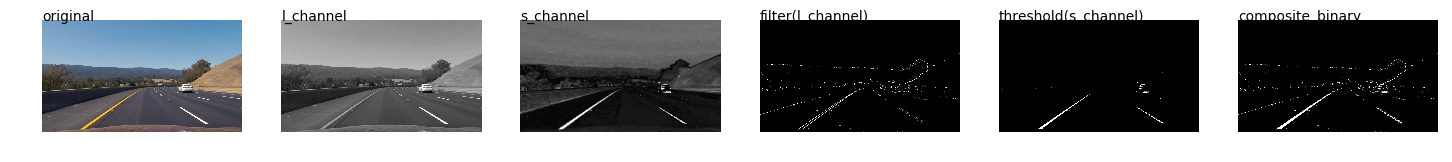

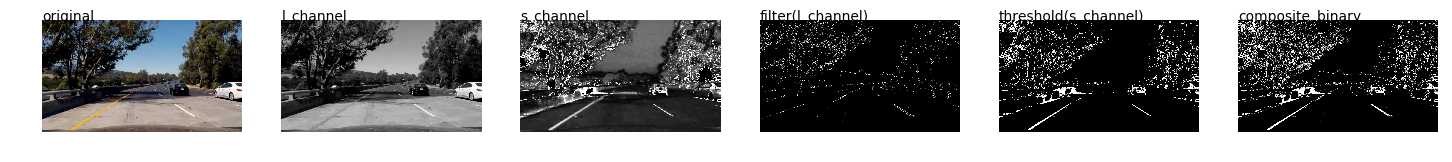

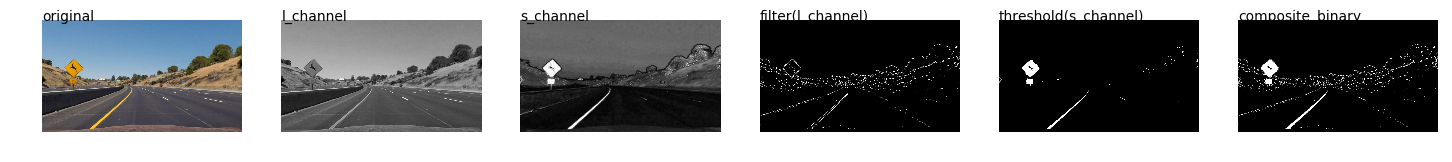

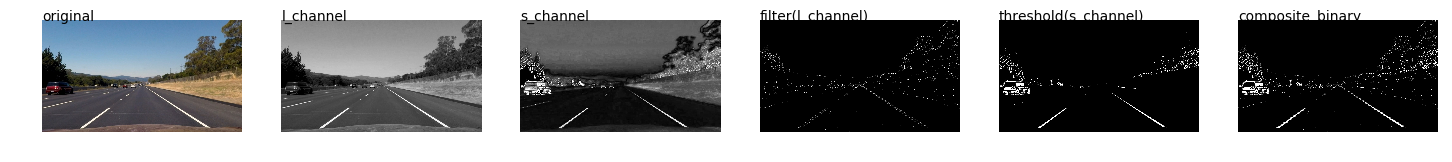

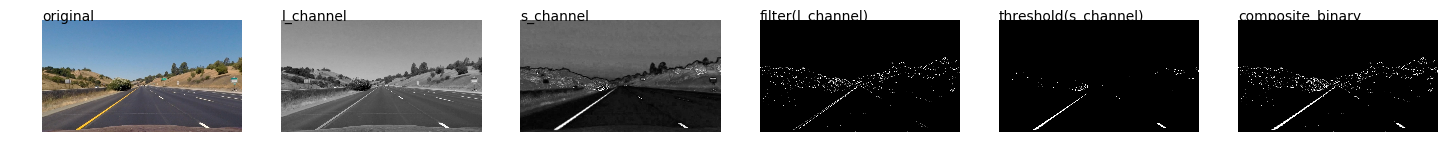

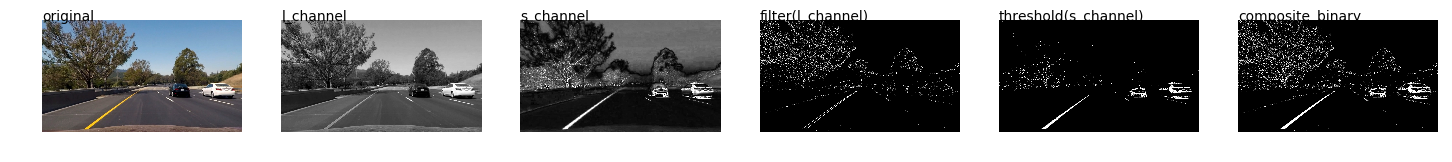

In [4]:
imgNo = 1
figNo = 1
def plotSubImage(img, caption):
    global imgNo
    plt.subplot(5, 6, imgNo)
    imgNo += 1
    plt.axis('off')

    scaledShape=(28, int(28.0*img.shape[1] / img.shape[0]))
    if len(img.shape) == 2:
        plt.imshow(img, shape=scaledShape, cmap='gray')
    else:
        plt.imshow(img, shape=scaledShape)
        
    plt.text(0, 0, caption, fontsize=10)

# produce a binary image with lane edges extracted
# return binary image
def extractLaneEdges(img, s_thresh=(170, 255), sx_thresh=(20, 100), mag_thresh=(30,100), dir_thresh=(0.6,1.4), visual=False):
    global figNo, imgNo

    # Convert to HLS color space and separate the L, S channels
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    #s_channel = hls[:,:,2]
    
    # Convert to HSV color space and separate the S, V channels
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
    s_channel = hls[:,:,2]

    # Sobel x & y
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    sobely = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1) # Take the derivative in y
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Calculate magnitude
    mag = np.sqrt(sobelx**2 + sobely**2)
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_mag = (255 * mag / np.max(mag)).astype(np.uint8)
    # Create a binary mask where mag thresholds are met
    #mask_mag = np.zeros_like(scaled_mag)
    #mask_mag[ (scaled_mag>=mag_thresh[0]) & (scaled_mag<=mag_thresh[1]) ] = 1
    
    # Calculate direction
    arctan = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    # Create a binary mask where direction thresholds are met
    #mask_dir = np.zeros_like(arctan)
    #mask_dir[ (arctan>=dir_thresh[0]) & (arctan<=dir_thresh[1]) ] = 1

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[
        (scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])
        & (scaled_mag>=mag_thresh[0]) & (scaled_mag<=mag_thresh[1])
        & (arctan>=dir_thresh[0]) & (arctan<=dir_thresh[1])
            ] = 1

    # Threshold saturation channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    composite_binary = np.zeros_like(s_binary)
    composite_binary[ (s_binary == 1) | (sxbinary==1)  ] = 1
    
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    if visual:
        imgNo = 1
        fig = plt.figure(figNo, (18.,15.))
        figNo += 1
        plotSubImage(img, "original")
        plotSubImage(l_channel,"l_channel")
        plotSubImage(s_channel,"s_channel")
        plotSubImage(sxbinary,"filter(l_channel)")
        plotSubImage(s_binary,"threshold(s_channel)")
        plotSubImage(composite_binary,"composite_binary")

    return composite_binary

images = glob.glob('test_images/*.jpg')

for fname in images:
    img = loadImage(fname)
    undist = cv2.undistort(img, data['CameraMatrix'], data['DistortionCoeff'], None, data['CameraMatrix'])
    result = extractLaneEdges(undist, visual=True)


## Perspetive transform for a bird's eye view

OpenCV's `perspectiveTransform` function is used to derive a bird's eye view of the lanes.
Undistorted images are transformed using a predetermined source and destination array of points.

The source coordinates are corners of the lane in 'test_images/straight_lines1.jpg'. 
The destination points were selected to make the lane appear vertial.

After `perspectiveTransform` is done, the lane lines near the top appear broken. To keep them together, I applied a dialation operation on the image using OpenCV's `dilate` function.

The inverse matrix of this transform is calculated for use later when augmenting camera image data.


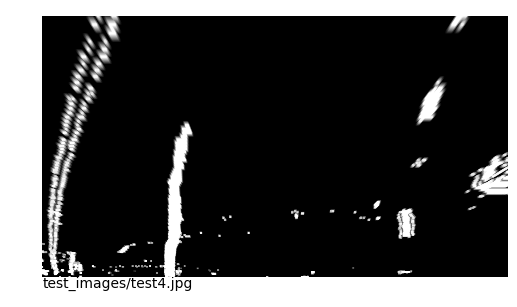

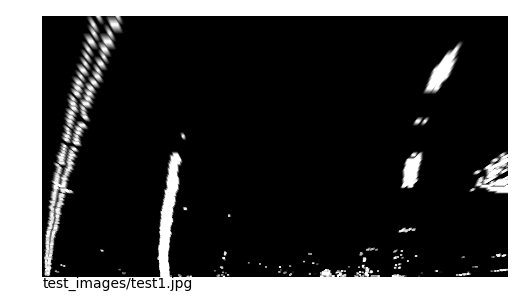

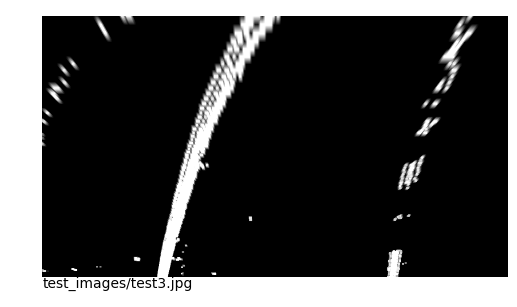

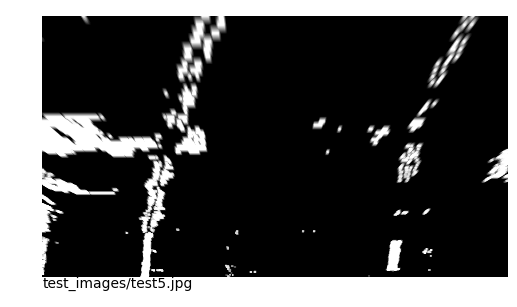

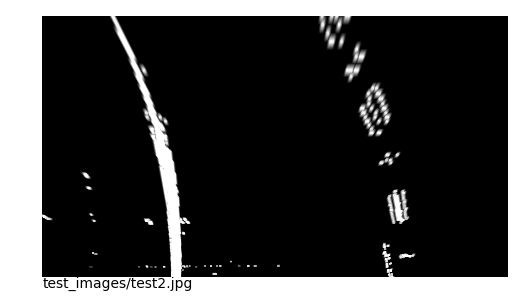

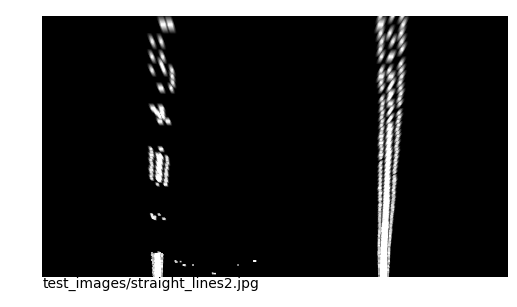

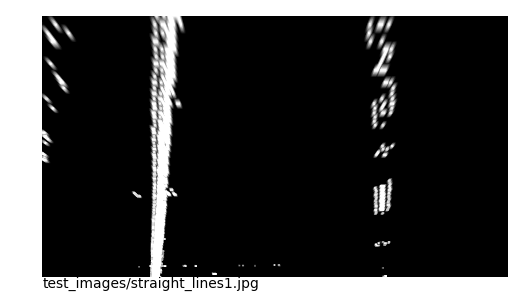

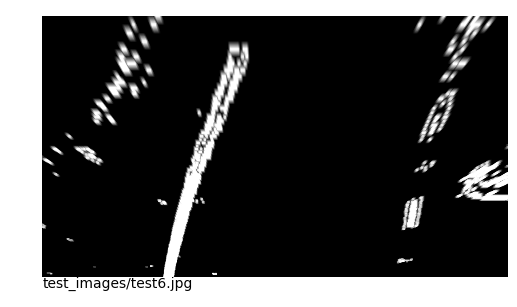

In [5]:
def getPerspectiveTransformMatrices(data):
    #src=np.array([(274,664),(613,437),(664,437),(1032,664)], dtype=np.float32)
    src=np.array([(288,656), (590,450), (687,450), (1022,656)], dtype=np.float32)
    dst=np.array([(300,720),(300,0),(950,0),(950,720)], dtype=np.float32)
    data['M'] = cv2.getPerspectiveTransform(src, dst)
    data['Minv'] = cv2.getPerspectiveTransform(dst, src)

# Do undistort and perspectiveTransform and store results in data dictionary
def birdsEyeView(img, data):
    undist = cv2.undistort(img, data['CameraMatrix'], data['DistortionCoeff'], None, data['CameraMatrix'])
    data['undistortedImage'] = undist
    result = extractLaneEdges(undist)
    warped = cv2.warpPerspective(result, data['M'], (result.shape[1], result.shape[0]), flags=cv2.INTER_LINEAR)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
    warped = cv2.dilate(warped,kernel,iterations = 1)
    data['birdsEyeViewImage'] = warped

for fname in images:
    img = loadImage(fname)
    getPerspectiveTransformMatrices(data)
    birdsEyeView(img, data)
    plotImg(data['birdsEyeViewImage'],fname)

## Lane line detection and Polynomial fitting

### Tracing lane lines
Function `traceLineEdges` implements lane line tracing using sliding window method.
 - **Locate first window**
   - Compute a histogram along the y axis for only the bottom half of the image.\
   - Find largest peak to the left and right of center
   - Use x value of peak as center of window
   - y value of first window is set to the bottom of the image (720)
   
 - **Trace lane line**
   - Compute histogram within window
   - Locate the outer edges of the lane line
   - Calculate the center of the lane line
   - Slide window to the lane line's center
   - Move window up and repeat process

 - **Fitting polynomial**
   - Every window location is added to a collection
   - Using numpy fitPoly method a 2nd degree polynomial is fit to the points in the collection

### Lane line tracking
Once a polynomial is known, every frame need not be scanned from scratch. Instead, the polynomial can be adjusted using points within a small margin around the fitted line.
Function `continueLaneFit` implements this update method.


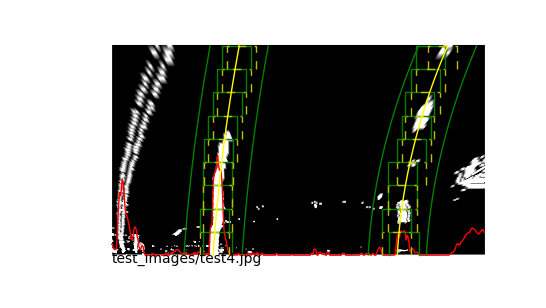

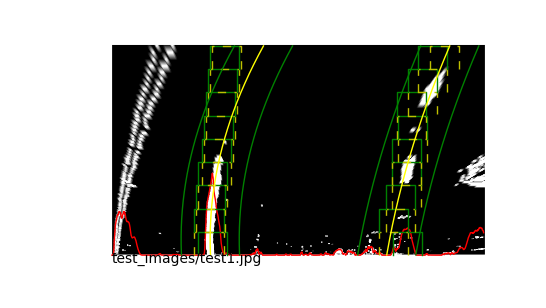

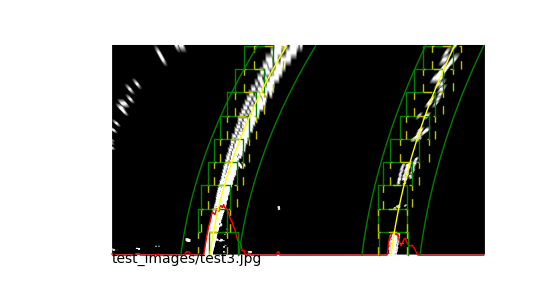

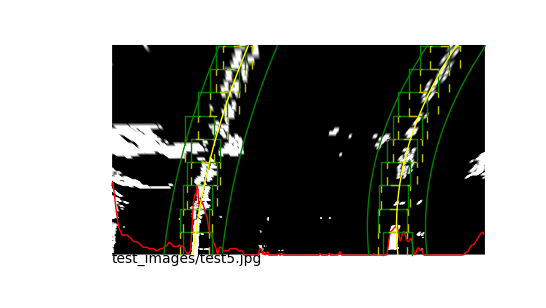

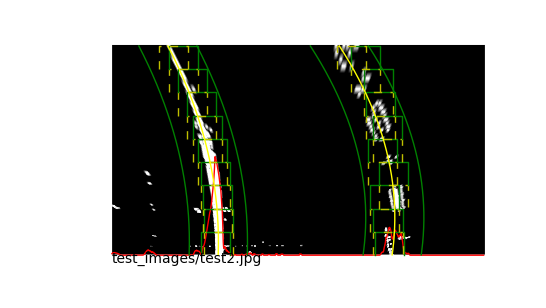

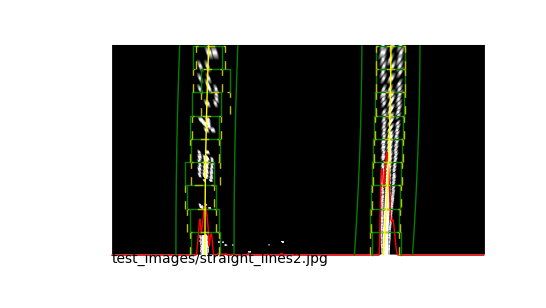

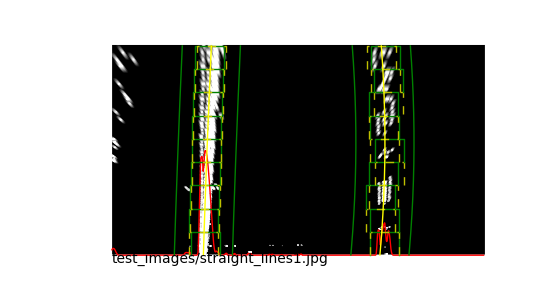

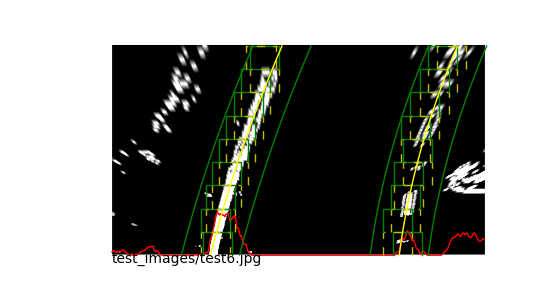

In [6]:
def getWorldScale(data):
    data['xm_per_pix'] = 3.7/700 # meters per pixel in x dimension
    data['ym_per_pix'] = 30/720 # meters per pixel in y dimension

# trace one lane line using sliding window method
# return fitted polynomial and polynomial scaled to real world scale
def traceLaneEdge(img, x, xm_per_pix, ym_per_pix, visualize=False):
    imgHeight = img.shape[0]
    zoneht = imgHeight // 9
    zonewd = 100
    delta = 0
    arrX = []
    arrY = []
    
    for y in range(imgHeight, 0, -zoneht):
        left = x - (zonewd // 2)
        right = x + (zonewd // 2)
        top = y - zoneht
        bottom = y
        if visualize:
            plt.plot([ left, left, right, right ], 
                     [ bottom, top, top, bottom ], 
                     'g-' )
            #print("(%d,%d) - (%d,%d)"%(left,top,right,bottom))

        hist = np.sum(img[top:bottom, left:right], axis=0).astype(np.uint8)
        #print("Histo {0} {1}".format(hist.shape, hist))
        
        blob = np.argwhere( hist > 20 )
        if len(blob) > 0:
            mid = int(np.median(blob))
            delta = (mid - (zonewd//2))
            #print(blob, mid, delta)
        else:
            mid = np.argmax(hist)
            if hist[mid] > 0:
                delta = (mid - (zonewd//2))
                #print(mid, delta)

        x += delta
        left = x - (zonewd // 2)
        right = x + (zonewd // 2)

        if visualize:
            plt.plot([ left, left, right, right ], 
                     [ bottom, top, top, bottom ], 
                     'y--' )
        
        arrX.append(x)
        arrY.append(y)
    
    fit = np.polyfit(arrY, arrX, 2)
    fit_scaled = np.polyfit(np.array(arrY) * ym_per_pix, np.array(arrX) * xm_per_pix, 2)
    return fit, fit_scaled

# trace both lane lines using sliding window method
# store fitted polynomials and scaled polynomials in data dictionary
def traceLaneEdges(data, visualize=False):
    img = data['birdsEyeViewImage']
    
    histogram = np.sum(img[img.shape[0]/2:,:], axis=0)
    
    if visualize:
        plt.plot(img.shape[0]-histogram, 'r-')
    
    histogram[0:100] = 0
    histogram[histogram.shape[0]-100:] = 0
    
    x = np.argmax(histogram[:histogram.shape[0]//2])
    y = int(histogram[x])
    leftFit, leftFit_scaled = traceLaneEdge(img, x, data['xm_per_pix'], data['ym_per_pix'], visualize=visualize)
    
    x = histogram.shape[0]//2 + np.argmax(histogram[histogram.shape[0]//2:])
    y = int(histogram[x])
    rightFit, rightFit_scaled = traceLaneEdge(img, x, data['xm_per_pix'], data['ym_per_pix'], visualize=visualize)
    
    data['leftLanePolynomial'] = leftFit
    data['leftLanePolynomialScaled'] = leftFit_scaled
    data['rightLanePolynomial'] = rightFit
    data['rightLanePolynomialScaled'] = rightFit_scaled
    
# scan for lane line within margin (+-100) of fitted polynomial line
# re-fit polynomial to points found within the margin
# store result back in data dictionary
def continueLaneFit(data):
    img = data['birdsEyeViewImage']
    left_fit = data['leftLanePolynomial']
    right_fit = data['rightLanePolynomial']
    
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    left_fit_scaled = np.polyfit(lefty*data['ym_per_pix'], leftx*data['xm_per_pix'], 2)
    right_fit_scaled = np.polyfit(righty*data['ym_per_pix'], rightx*data['xm_per_pix'], 2)

    data['leftLanePolynomial'] = left_fit
    data['leftLanePolynomialScaled'] = left_fit_scaled
    data['rightLanePolynomial'] = right_fit
    data['rightLanePolynomialScaled'] = right_fit_scaled

# compute x coordinates given a range of y coordinates, using fitted polynomials in data dictionary
def computeFitLines(fity, data):
    left_fit = data['leftLanePolynomial']
    right_fit = data['rightLanePolynomial']
    # Generate x and y values for plotting
    #fity = np.linspace(y_low, y_high-1, y_high)
    fit_leftx = left_fit[0]*fity**2 + left_fit[1]*fity + left_fit[2]
    fit_rightx = right_fit[0]*fity**2 + right_fit[1]*fity + right_fit[2]    
    return (fity, fit_leftx, fit_rightx)

# draw line representing the fitted polynomial
def plotFitLine(imgHeight, fit):
    fy = np.arange(imgHeight)
    fx = fit[0]*fy**2 + fit[1]*fy + fit[2]
    plt.plot(fx, fy, color='yellow')

# fit lines with both sliding window and incremental adjustment method
# visualize results
def fitLanes(img, data, fname="", visualize=False):
    
    birdsEyeView(img, data)
    warped = data['birdsEyeViewImage']
    
    if visualize:
        plotImg(warped,fname)
    
    traceLaneEdges(data, visualize)
    
    continueLaneFit(data)
    
    if visualize:
        margin = 100
        fity, fit_leftx, fit_rightx = computeFitLines(np.arange(0,warped.shape[0]),data)
        plt.plot(fit_leftx-margin, fity, color='green')
        plt.plot(fit_leftx+margin, fity, color='green')
        plt.plot(fit_rightx-margin, fity, color='green')
        plt.plot(fit_rightx+margin, fity, color='green')
        plotFitLine(warped.shape[0], data['leftLanePolynomial'])
        plotFitLine(warped.shape[0], data['rightLanePolynomial'])
        
# Drive operation on all test images
for fname in images:
    img = loadImage(fname)
    getWorldScale(data)
    fitLanes(img, data, fname, visualize = True)

Curvature Calculation

Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.
Here the idea is to take the measurements of where the lane lines are and estimate how much the road is curving and where the vehicle is located with respect to the center of the lane. The radius of curvature may be given in meters assuming the curve of the road follows a circle and the position of the vehicle within the lane may be given as meters off of center. 

## Curvature Calculation

With polynomials fitted to the lane edges and scaled to world coordinates, I can compute the curvature of the lane lines using the following equation implemented in the `calcCurve` function.

$$R_{curve} = \frac{(1+(2A_y + B)^2)^{3/2}}{|2A|}$$

Where A,B are coefficients from the lane polynomial $$f(y)=Ay^2+By+C$$

The gap between the lane lines can be measured from subtracting x coordinates along certain y-values and taking an average - see function `computeGap` below.

Likewise, calculating the lane center from right and left lane points at the bottom of the image lets me calculate how much the image is off-center. Negative value indicates car has shifted to the left of the lane.

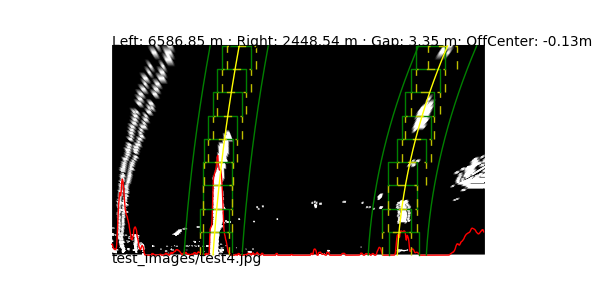

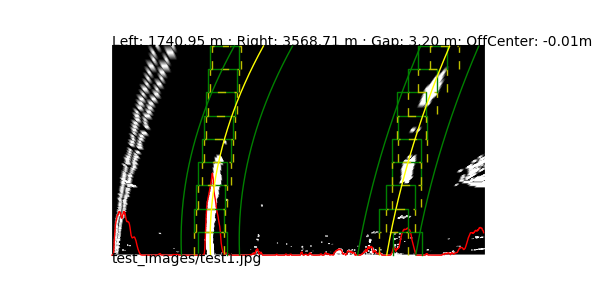

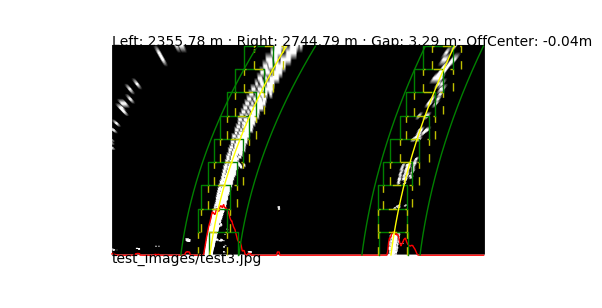

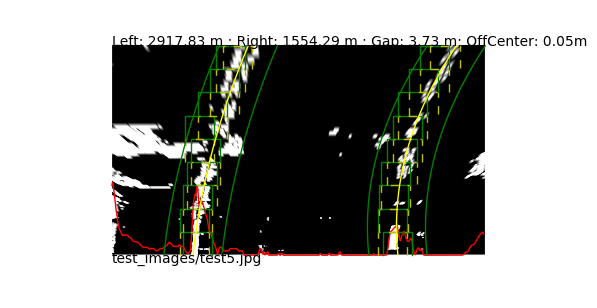

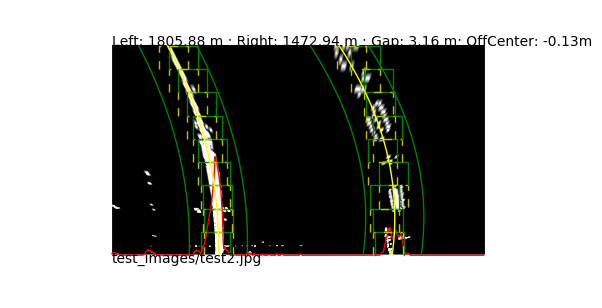

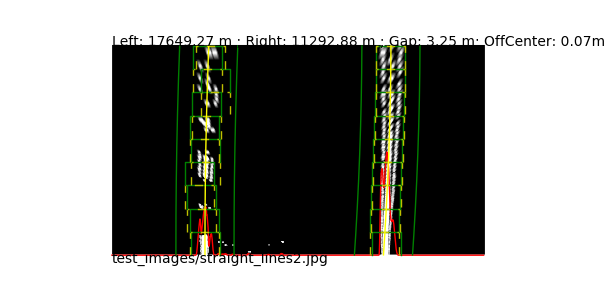

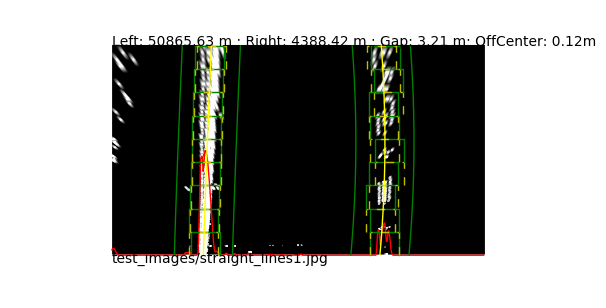

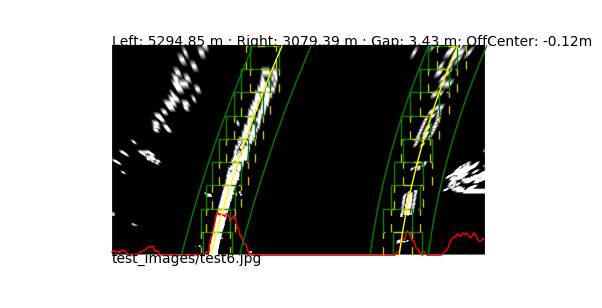

In [7]:
def calcCurve(data):
    left_fit = data['leftLanePolynomial']
    right_fit = data['rightLanePolynomial']
    y_eval = data['birdsEyeViewImage'].shape[0]
    left_curve_rad = ((1 + (2*left_fit[0]*y_eval*data['ym_per_pix'] + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curve_rad = ((1 + (2*right_fit[0]*y_eval*data['ym_per_pix'] + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    data['leftLaneCurvature'] = left_curve_rad
    data['rightLaneCurvature'] = right_curve_rad

def computeGap(data):
    height = data['birdsEyeViewImage'].shape[0]
    width = data['birdsEyeViewImage'].shape[1]
    # get lane points at the bottom of the image to calculate width and lane center
    fity, fit_leftx, fit_rightx = computeFitLines(np.array([height, height-100]), data)
    gaps = fit_rightx - fit_leftx
    # lane width
    data['laneGapPixels'] = gaps[0]
    # scale to world coordinates
    data['laneGap'] = data['laneGapPixels'] * data['xm_per_pix']
    center = (fit_leftx[0] + (fit_rightx[0] - fit_leftx[0])//2)
    # calculate meters off center
    data['offCenter'] = ((data['birdsEyeViewImage'].shape[1]//2) - center) * data['xm_per_pix']
    # change in width - as a measure of polynomial quality
    data['laneWidthDifference'] = gaps[0]-gaps[1]

# Drive lane detection and print curvature and lane gap
for fname in images:
    img = loadImage(fname)
    fitLanes(img, data, fname, visualize=True)
    calcCurve(data)
    computeGap(data)

    plt.text(0,0,"Left: %.2f m ; Right: %.2f m ; Gap: %.2f m; OffCenter: %.2fm"%(data['leftLaneCurvature'], data['rightLaneCurvature'], data['laneGap'], data['offCenter']))
    

## Augmenting Images

Camera images are augmented using OpenCV functions to overlay lane data on top of the undistorted image.

1. Lane outlines in bird's eye view perspective are rendered on a blank image 'mask'.
2. Mask image is then converted back to original image space by applying an inverse perspective transform, using the inverse transformation matrix calculated earlier.
3. Mask is overlaid on top of the undistorted original image using OpenCV `addWeighted` function.



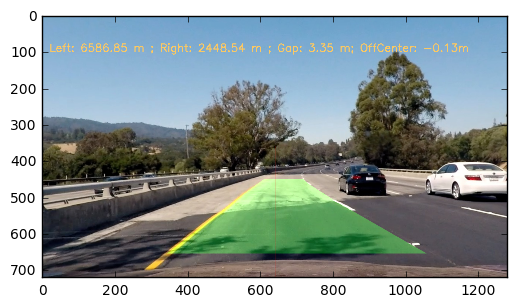

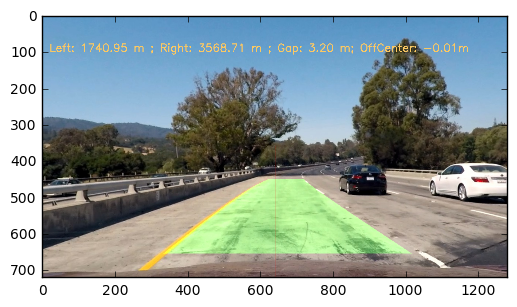

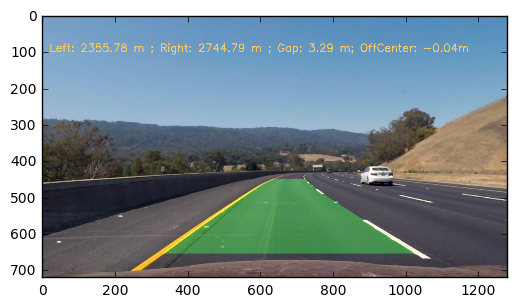

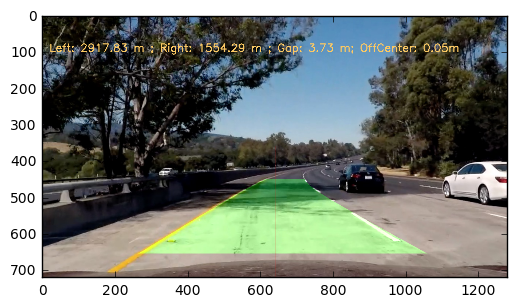

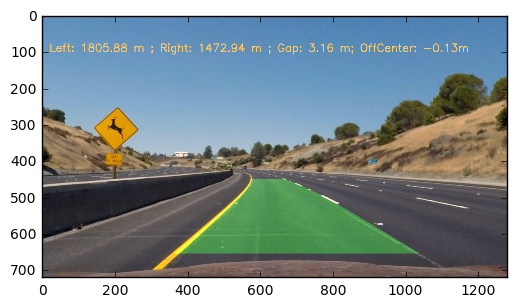

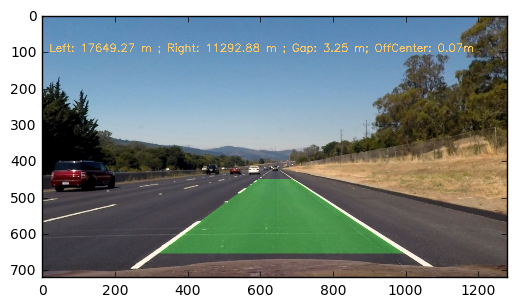

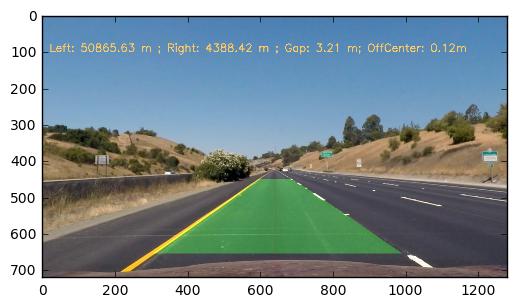

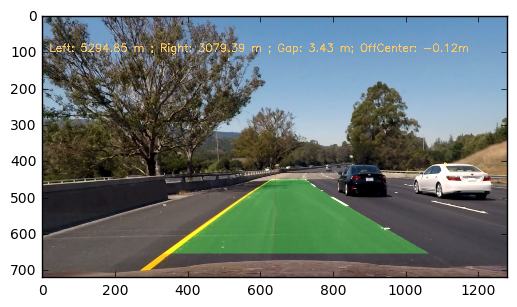

In [8]:
def stampText(img, txt):
    cv2.putText(img, txt, (20,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (250,200,100), 2)

def augmentImage(data):
    ploty, left_fitx, right_fitx = computeFitLines(np.arange(0, data['birdsEyeViewImage'].shape[0]), data)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(data['birdsEyeViewImage']).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    undist = data['undistortedImage']
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, data['Minv'], (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    # Draw center line
    cv2.line(result, (result.shape[1]//2, result.shape[0]//2), (result.shape[1]//2, result.shape[0]), (255,0,0))
    stampText(result, "Left: %.2f m ; Right: %.2f m ; Gap: %.2f m; OffCenter: %.2fm"%(data['leftLaneCurvature'], data['rightLaneCurvature'], data['laneGap'], data['offCenter']))

    data['augmentedImage'] = result
    
for fname in images:
    img = loadImage(fname)
    fitLanes(img, data, fname)
    calcCurve(data)
    computeGap(data)
    augmentImage(data)
    plt.figure()
    plt.imshow(data['augmentedImage'])


## Pipeline for Video
All the above functions are sequenced into a simple `processImage` function that takes in a frame from a video and returns an augmented frame for output encoding.

On startup, camera calibration is done along with calculating transformation matrices and scaling factors.

On the first image and whenever the program loses track of the lanes, it will do a scan for the lane lines using `traceLaneEdges` function. 
Once a polynomial has been fitted, I use that in subsequent frames to track the lanes.

I use lane gap as a way to tell if what we are tracking is actually a lane.

All data and image references are stored in `data` dictionary. This dictionary is a convenient way to facilitate information sharing between functions defined above.

Using the `moviepy` project, frames from the input video are run through `processImage` function and augmented output is written out to an output .mp4 file.

In [9]:
# data dictionary containing images, data
data={'haveLines': False, 'totalFrames': 0, 'tracedFrames': 0}

def processImage(img):
    global data

    birdsEyeView(img, data)    

    if data['haveLines']:
        continueLaneFit(data)
        computeGap(data)
        # Sanity check
        if data['laneGapPixels'] < 600 or data['laneGapPixels'] > 700 :
            data['haveLines'] = False
        if np.absolute(data['laneWidthDifference']) > 10:
            data['haveLines'] = False

    if not data['haveLines']:
        traceLaneEdges(data)
        data['tracedFrames'] += 1
        computeGap(data)
        data['haveLines'] = True

    calcCurve(data)

    augmentImage(data)
    data['totalFrames'] += 1
    return data['augmentedImage']


# Camera calibration
calibrateCamera(data, 'camera_cal/calibration*.jpg')

# Perspective transform matrices
getPerspectiveTransformMatrices(data)

# Set world scale
getWorldScale(data)

clip1 = VideoFileClip("project_video.mp4")
modifiedClip = clip1.fl_image(processImage) #NOTE: this function expects color images!!
%time modifiedClip.write_videofile('project_video.out.mp4', audio=False)

print("Total frames: %d, Traced frames: %d"%(data['totalFrames'], data['tracedFrames']))

[MoviePy] >>>> Building video project_video.out.mp4
[MoviePy] Writing video project_video.out.mp4


100%|█████████▉| 1260/1261 [03:16<00:00,  6.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video.out.mp4 

CPU times: user 24min 31s, sys: 7.56 s, total: 24min 38s
Wall time: 3min 16s
Total frames: 1261, Traced frames: 395


In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('project_video.out.mp4'))

## Discussion

### Limitations
This method relies on the road being perfectly flat as the lane edge scanning algorithm uses constant, hand-picked values for creating histograms and tracing edges.

Lane extraction using color and gradient thresholds that are also hand-picked to work well on these specific samples will limit effectiveness on other types of roads. This approach won't work well for other road and weather conditions (like snow) as different threshold values would be required to work.

Vehicles in front of the car would interfere with lane detection as their presence would alter histogram values and lead to fitting incorrect polynomials.

